Genetic Algorithm เป็นเทคนิคสำหรับค้นหาผลเฉลย (solutions) หรือคำตอบโดยประมาณของปัญหา โดยอาศัยหลักการจากทฤษฎีวิวัฒนาการจากชีววิทยา และ การคัดเลือกตามธรรมชาติ (natural selection) นั่นคือ สิ่งมีชีวิตที่เหมาะสมที่สุดจึงจะอยู่รอด กระบวนการคัดเลือกได้เปลี่ยนแปลงสิ่งมีชีวิตให้เหมาะสมยิ่งขึ้น ด้วยตัวปฏิบัติการทางพันธุกรรม (genetic operator) เช่น การสืบพันธุ์ (inheritance หรือ reproduction) , การกลายพันธุ์ (mutation) , การแลกเปลี่ยนยีน (recombination)

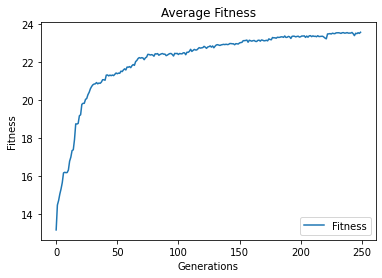

In [21]:
import random
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')

class World:
    cell_dict = {}

class Cell:
    """
    Organism, that has a DNA.
    """
    number = 0
    def __init__(self, dna=None, n_chromosomes = 6, n_genes = 1, dict_entry=True):
        if dict_entry:
            self.number = Cell.number
            Cell.number += 1

        self.mutation_chance = 0.1
        self.n_mutations = 1

        if dna is not None:
            self.dna = dna
        else:
            self.dna = self._random_dna(n_chromosomes, n_genes)

        if dict_entry:
            World.cell_dict[self.number] = self

    def _random_dna(self, n_chromosomes=4, n_genes=2):
        """
        Generates a random DNA for Cell.
        :param n_chromosomes: Number of chromosomes.
        :param n_genes: Number of genes inside 1 Chromosome.
        :return: random DNA; example: [[0.1,0.3],[0.3,0.7],[0.9,0.1],[0.2,0.6]]
        """
        dna = [[] for _ in range(n_chromosomes)]
        for _ in range(n_genes):
            for n in range(len(dna)):
                dna[n].append(random.random())
        return dna

    def mate(self, partner, dict_entry=True):
        """
        Produces a new Cell individual with partner.
        :param partner: type Cell, partner with which to produce child.
        :return: DNA of the produced child. (type list)
        """
        dna1 = self.dna
        dna2 = partner.dna

        # --- Crossover
        child_dna = []
        for n in range(len(dna1)):
            parent_chromosome = random.randint(0, 1)
            if parent_chromosome == 0:
                child_dna.append(dna1[n])
            elif parent_chromosome == 1:
                child_dna.append(dna2[n])

        # --- Mutation
        if random.random() < self.mutation_chance:
            mutation_idx1 = []
            mutation_idx2 = []
            for _ in range(self.n_mutations):
                mutation_idx1.append(random.randint(0, len(child_dna) - 1))
                mutation_idx2.append(random.randint(0, len(child_dna[0]) - 1))
            mutated_dna = []
            for y, chrom in enumerate(child_dna):
                mutated_dna.append([])
                for x, gene in enumerate(chrom):
                    for id, idx in enumerate(mutation_idx1):
                        ok = True
                        if y == idx and x == mutation_idx2[id]:
                            mutated_dna[y].append(random.random())
                            ok = False
                            break
                    if ok:
                        mutated_dna[y].append(gene)
            child_dna = mutated_dna
        child_cell = Cell(dna=child_dna, dict_entry=dict_entry)
        return child_cell

    def _get_fitness(self):
        """
        Calculates the fitness of this cell.
        :return: Fitness
        """
        single_dim = [j for sub in self.dna for j in sub]
        normalized = self._mean_normalize(single_dim)
        return sum(normalized)

    def _mean_normalize(self, data):
        """
        Applies mean normalization to a single dimension list of values.
        :param data: type list, filled with values
        :return: returns list with all values normalized (0-1)
        """
        newdata = []
        for d in data:
            norm = 1 / (max(data) - min(data)) * (d - max(data)) + 1 #(max'-min') / (max - min) * (value - max) + max'
            newdata.append(norm)
        return newdata

    def get_similarity(self, other_cell):
        """
        Function to calculate similarity of DNAs.
        :param other_cell: type Cell, to compare DNAs with.
        :return: Similarity of the two cells in percent.
        """
        dna1 = self.dna
        dna2 = other_cell.dna
        max_similarity = len([j for sub in dna1 for j in sub])
        n_similar = 0
        for num, chromosome1 in enumerate([j for sub in dna1 for j in sub]):
            chromosome2 = [j for sub in dna2 for j in sub][num]
            if chromosome1 == chromosome2:
                n_similar += 1
        if n_similar == 0:
            return 0
        similarity = n_similar / max_similarity
        return similarity

    def __repr__(self):
        return str(self.dna)

class Population:
    """
    Main class for controlling the genetic algorithm.
    """
    def __init__(self, n_population=50, n_generations=100):
        self.n_population = n_population
        self.n_generations = n_generations

        self.population = []
        self.fitness_plot = []

    def selection(self, n_selected):
        """
        Uses a selection process to select the next n_selected parents for further breeding.
        :return: The selected Cells. type list. selection(2) returns [Cell, Cell]
        """
        selection = []

        fitness_list = [(c.number, c._get_fitness()) for c in self.population]
        sorted_values = sorted(fitness_list, key=lambda x: x[1], reverse=True)
        for n in range(n_selected):
            selection.append(World.cell_dict[sorted_values[n][0]])

        return selection

    def advanced_selection(self, n_selected):
        """
        Uses a advanced selection process to select the parents with the best outcome for the next generation.
        :param n_selected: Placeholder if someone used old function with same parameters.
        :return: The selected Cells. type list.
        """
        selection = []
        n_preselected = random.randint(2,10)
        fitness_list = [(c.number, c._get_fitness()) for c in self.population]
        sorted_values = sorted(fitness_list, key=lambda x: x[1], reverse=True)
        preselected = [y[0] for y in sorted_values[:n_preselected]]
        combinations = {}
        for p1 in preselected:
            p1_cell = World.cell_dict[p1]
            for p2 in preselected:
                p2_cell = World.cell_dict[p2]
                child = p1_cell.mate(p2_cell, dict_entry=False)
                combinations[f"{p1}-{p2}"] = child._get_fitness()
        sorted_values = sorted(combinations.items(), key=lambda x: x[1], reverse=True)
        best = sorted_values[0][0].split("-")
        selection.append(World.cell_dict[int(best[0])])
        selection.append(World.cell_dict[int(best[1])])
        return selection


    def next_generation(self):
        """
        Breeds next generation.
        :return: This generation's population, The fitness plot up to this point
        """
        selection = self.advanced_selection(n_selected=2)

        self.population = []
        for pop_idx in range(self.n_population):
            self.population.append(selection[0].mate(selection[1]))

        # --- Statistics ---
        fitness_list = [c._get_fitness() for c in self.population]
        self.fitness_plot.append(sum(fitness_list) / len(fitness_list))

        return self.population, self.fitness_plot

    def plot_stats(self):
        """
        Plots the fitness over all generations using matplotlib.
        """
        plt.plot(self.fitness_plot)
        plt.title('Average Fitness')
        plt.ylabel('Fitness')
        plt.xlabel('Generations')
        plt.legend(['Fitness'], loc='lower right')
        plt.show()

    def run(self):
        for _ in range(self.n_generations):
            self.next_generation()
        return self.population, self.fitness_plot

if __name__ == "__main__":
    # --- Adam and Eve
    adam = Cell(n_chromosomes=5, n_genes=5)
    eve = Cell(n_chromosomes=5, n_genes=5)

    pop = Population(n_population=50, n_generations=250)
    pop.population.append(adam)
    pop.population.append(eve)
    pop.run()

    pop.plot_stats()